## 캐글 따라하기 (kaggle_Bike Sharing Demand) + Using **XGBoost**



이번 블로그는 캐글에서 돌아다니는 bike sharing demand의 대해 **XGBoost**를 사용할 것이다.

- Reference:
    - [미래를위한취미_kaggle_Bike Sharing Demand[입문자용]](https://seethefuture.tistory.com/101)
    - [미래를위한취미_XGBoost개념이해](https://seethefuture.tistory.com/91)


앞으로 진행할 프로젝트의 최종 목표는 학습 데이터로 모델을 학습시킨 후 공공자전거의 수요량을 예측하는 것이다. 즉, 테스트 데이터 정보(features, 종속변수)를 바탕으로 제출용 데이터의 'count'(target, 독립변수)를 예측하는 것이다.

- 지도학습중에 분류와 회귀중 회귀와 관련 된 문제 => 자전거 대여량을 예측하는 문제이기 때문에
    - 캐글의 타이타닉 생존자 의 경우는 분류와 회귀 중에 분류에 속한다 => 생존여부를 가려내야 하는 문제이기 때문에


- 간략한 도메인 지식

워싱턴 D.C 소재의 자전거 대여 스타트업 회사인 Capital BikeShare의 데이터를 활용하여 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 과제이다. 데이터 분석과 시각화, 머신 러닝 알고리즘을 이용하여 시간당 자전거 대여량을 예측할 예정입니다. 사람들이 자전거를 대여하는데는 많은 요소가 관여하고 있다. 예로는 새벽보다는 낮시간이 더 많을 것이고, 날씨에도 영향을 받아 비가오는 날에는 엄청 줄을 것이다.근무 시간보다는 여가시간에 자전거를 더 많이 대여할 것이다. 프로그래밍 지식, 인공 지능, 머신 러닝 지식을 제외하고, 자전거 렌탈 시장에 대한 도메인지식과 우리가 자전거를 탔을때의 경험과 기초상식 등을 총 동원해서 효율적인 예측을 해보자.












#### 분석 및 예측에 사용된 라이브러리

- Juppter Notebook: 웹 브라우저 기반 편집 환경
- Python: 쉽고 명확한 범용적 프로그래밍 언어
- Pandas: Python 기반의 데이터 분석 및 처리 라이브러리
- Numpy: Python 기반의 쉽고 빠른 과학 연산 라이브러리
- Seaborn: Python 기반의 시각화 라이브러리
- Scikit-Learn: Python 기반의 머신러닝 관련 라이브러리
- XGBoost: 학습에 사용될 Gradient Boosting 알고리즘이 구현된 라이브러리

 #### Column 종류 및 설명
 
- datetime: 년-월-일 시간 데이터
- season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
- holiday: 공휴일 또는 주말
- workingday: 공휴일, 주말을 제외한 평일
- weather
    - 1: 매우 맑음(Clear, Few clouds, Partly cloudy, Partly cloudy)
    - 2: 맑음(Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist)
    - 3: 나쁨(Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)
- 4: 매우 나쁨(Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)
- temp: 기온
- atemp: 체감온도 정도로 보자
- humidity: 상대 습도
- windspeed: 바람의 세기
- casual: 미등록 사용자 렌탈 수
- registered: 등록된 사용자 렌탈수
- count: 렌탈한 총 합

In [65]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [66]:
# 한글폰트
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


#### Step 1. Data Load 

In [67]:
train = pd.read_csv('./kaggle_Bike Sharing Demand/train.csv')
test = pd.read_csv('./kaggle_Bike Sharing Demand/test.csv')

데이터가 제대로 불러와졌는지를 확인을 위해 train.head()를 실행시켜보자. 불러온 train이라는 dataframe 중에서 앞의 5개의 열을 출력시킬 수 있다.

In [68]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [69]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


tset 셋에서 casual, registered, count 를 결측값으로 만든다.

In [70]:
test['casual'] = np.nan
test['registered'] = np.nan
test['count'] = np.nan

In [71]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN


- NaN 값 확인

In [72]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      

datetime형식으로 바꿔주자

In [73]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [74]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None


- datetime 이 object에서 datetime64[ns]로 바뀐 것을 확인

datetime으로 되어있는 데이터를 좀 더 나누어서 보자. (년)year,(월)month,(일)day,(시간)hour로 나누어 추가해보자.

train셋에 적용

In [75]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['DOW'] = train['datetime'].dt.dayofweek
train['hour'] = train['datetime'].dt.hour

In [76]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


- columns이 늘어난 것을 확인. ((년)year,(월)month,(일)day,(시간)hour)

test 셋에도 적용

In [77]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['DOW'] = test['datetime'].dt.dayofweek
test['hour'] = test['datetime'].dt.hour

In [102]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN,2011,1,3,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN,2011,1,3,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN,2011,1,3,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN,2011,1,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN,2011,1,3,4


In [78]:
col = ['workingday','temp','year','month','DOW', 'hour']
x = train[col]
y = train['count']

In [79]:
X_test = test[col]
Y_test = test['count']

In [80]:
from sklearn.model_selection import train_test_split
X_train , X_valid ,Y_train , Y_valid = train_test_split(x,y,test_size = 0.25, random_state = 201)

In [81]:
def RSMLE(predictions , realizations):
    predictions_use = predictions.clip(0)
    rmsle = np.sqrt(np.mean(np.array(np.log(predictions_use+1)-np.log(realizations+1))**2))
    return rmsle

DecisionTreeRegressor 결정트리 회귀

In [82]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_split=25 , random_state=201)
dtr_model = dtr.fit(X_train,Y_train)

In [83]:
dtr_pred = dtr_model.predict(X_valid)

In [84]:
pd.DataFrame(dtr_model.feature_importances_,index=col)

,0
workingday,0.036680
temp,0.082574
year,0.096813
month,0.070877
DOW,0.052269
hour,0.660788


Text(0, 0.5, 'y_valid')

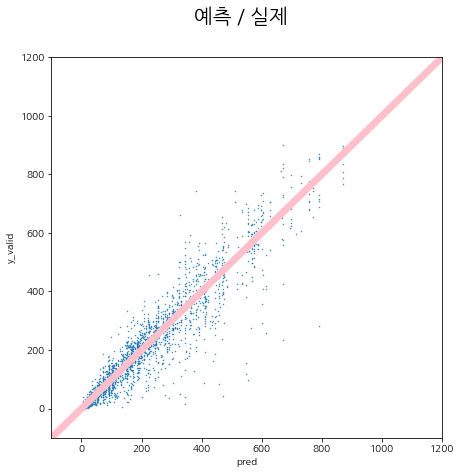

In [85]:
plt.figure(figsize=(7,7))
plt.scatter(dtr_pred,Y_valid, s=0.2)
plt.xlim(-100,1200)
plt.ylim(-100,1200)
plt.plot([-100,1200],[-100,1200],color = 'pink', linestyle = '-', linewidth =7)
plt.suptitle("예측 / 실제", fontsize = 20 )
plt.xlabel('pred')
plt.ylabel("y_valid")

In [86]:
RSMLE(dtr_pred,Y_valid)

0.3966703555172774

RandomForestRegressor

In [87]:
from sklearn.ensemble import RandomForestRegressor
regress = RandomForestRegressor(n_estimators=500, max_features=4,min_samples_leaf=5, random_state=201)
regress.fit(X_train,Y_train)

RandomForestRegressor(max_features=4, min_samples_leaf=5, n_estimators=500,
                      random_state=201)

In [88]:
predict = regress.predict(X_valid)

Text(0, 0.5, 'y_valid')

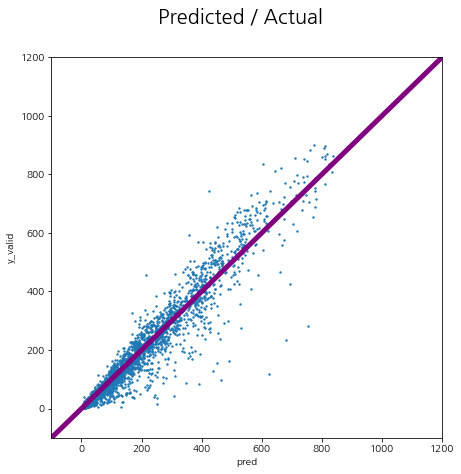

In [89]:
plt.figure(figsize=(7,7))
plt.scatter(predict,Y_valid, s=1.9)
plt.xlim(-100,1200)
plt.ylim(-100,1200)
plt.plot([-100,1200],[-100,1200],color = 'purple', linestyle = '-', linewidth =5)
plt.suptitle("Predicted / Actual", fontsize = 20 )
plt.xlabel('pred')
plt.ylabel("y_valid")

In [90]:
RSMLE(predict,Y_valid)

0.37402987325452597

***XGBoosted Tree Model

In [91]:
import xgboost as xgb
xgb_train = xgb.DMatrix(X_train,label=Y_train)
xgb_valid = xgb.DMatrix(X_valid)

In [92]:
num_round_for_cv = 500
param = { 'max_depth': 6 , 'eta':0.1 , 'seed' : 201 , 'objective' : 'reg:linear'}

In [93]:
xgb.cv(param,xgb_train,num_round_for_cv,nfold=5,show_stdv=False,verbose_eval=True,as_pandas=False)

[12:16:22] WARNING: /tmp/pip-build-2kqwo3v0/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:22] WARNING: /tmp/pip-build-2kqwo3v0/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:22] WARNING: /tmp/pip-build-2kqwo3v0/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:22] WARNING: /tmp/pip-build-2kqwo3v0/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:22] WARNING: /tmp/pip-build-2kqwo3v0/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:241.97717	test-rmse:242.02544
[1]	train-rmse:222.11095	test-rmse:

[164]	train-rmse:38.08603	test-rmse:49.03392
[165]	train-rmse:38.06505	test-rmse:49.02221
[166]	train-rmse:38.03120	test-rmse:49.02343
[167]	train-rmse:37.99910	test-rmse:49.02219
[168]	train-rmse:37.95966	test-rmse:49.01459
[169]	train-rmse:37.92178	test-rmse:49.00063
[170]	train-rmse:37.88822	test-rmse:48.98985
[171]	train-rmse:37.84269	test-rmse:48.97930
[172]	train-rmse:37.80172	test-rmse:48.97871
[173]	train-rmse:37.72134	test-rmse:48.94799
[174]	train-rmse:37.67523	test-rmse:48.93680
[175]	train-rmse:37.63636	test-rmse:48.93449
[176]	train-rmse:37.59618	test-rmse:48.93206
[177]	train-rmse:37.53969	test-rmse:48.93100
[178]	train-rmse:37.47426	test-rmse:48.90595
[179]	train-rmse:37.42588	test-rmse:48.89120
[180]	train-rmse:37.36147	test-rmse:48.87956
[181]	train-rmse:37.31321	test-rmse:48.86687
[182]	train-rmse:37.25089	test-rmse:48.84604
[183]	train-rmse:37.20061	test-rmse:48.84957
[184]	train-rmse:37.14028	test-rmse:48.84426
[185]	train-rmse:37.07681	test-rmse:48.82884
[186]	trai

[347]	train-rmse:31.26100	test-rmse:48.00158
[348]	train-rmse:31.23277	test-rmse:47.99133
[349]	train-rmse:31.21184	test-rmse:47.99237
[350]	train-rmse:31.18328	test-rmse:47.99455
[351]	train-rmse:31.15425	test-rmse:47.99240
[352]	train-rmse:31.13032	test-rmse:47.98766
[353]	train-rmse:31.11047	test-rmse:47.99009
[354]	train-rmse:31.08950	test-rmse:47.99073
[355]	train-rmse:31.06581	test-rmse:47.98453
[356]	train-rmse:31.04860	test-rmse:47.98595
[357]	train-rmse:31.00711	test-rmse:47.98294
[358]	train-rmse:30.98556	test-rmse:47.98295
[359]	train-rmse:30.94882	test-rmse:47.97327
[360]	train-rmse:30.91044	test-rmse:47.96494
[361]	train-rmse:30.88012	test-rmse:47.97338
[362]	train-rmse:30.86067	test-rmse:47.96735
[363]	train-rmse:30.82321	test-rmse:47.96803
[364]	train-rmse:30.78995	test-rmse:47.96946
[365]	train-rmse:30.75497	test-rmse:47.96510
[366]	train-rmse:30.72372	test-rmse:47.95856
[367]	train-rmse:30.69963	test-rmse:47.95806
[368]	train-rmse:30.67687	test-rmse:47.96793
[369]	trai

{'train-rmse-mean': [241.9771698,
  222.11094659999998,
  204.36871639999998,
  188.82299519999998,
  174.66977260000004,
  162.2172364,
  151.384491,
  141.92839679999997,
  132.98999020000002,
  124.76221000000001,
  117.28960119999999,
  110.4240114,
  104.47077940000001,
  98.9146622,
  93.9522844,
  89.4888884,
  85.4792174,
  82.3523072,
  79.41137540000001,
  76.5339994,
  74.137395,
  71.842659,
  69.9855346,
  68.29591680000001,
  66.46961339999999,
  64.2676384,
  62.4159134,
  60.71028,
  59.300544,
  58.417604,
  57.321482,
  56.2024644,
  55.4819274,
  54.779952200000004,
  54.2231368,
  53.6062942,
  53.0582848,
  52.59672099999999,
  52.14021220000001,
  51.7051842,
  51.3431106,
  50.9639824,
  50.5411072,
  50.2649208,
  49.984733600000006,
  49.7639778,
  49.55907739999999,
  49.247200799999995,
  49.0054832,
  48.764212,
  48.5634668,
  48.3926292,
  48.1706918,
  47.9452566,
  47.6823304,
  47.5140502,
  47.393406600000006,
  47.1247316,
  46.960040600000006,
  46.8

In [94]:
num_round = 400
xg_model = xgb.train(param,xgb_train,num_round)
xg_pred = xg_model.predict(xgb_valid)

[12:16:33] WARNING: /tmp/pip-build-2kqwo3v0/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [95]:
xg_model.get_fscore()

{'hour': 6278,
 'workingday': 1090,
 'month': 3312,
 'year': 1696,
 'DOW': 3600,
 'temp': 5497}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

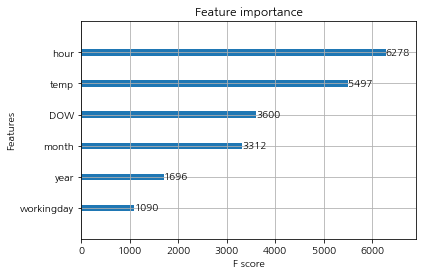

In [96]:
xgb.plot_importance(xg_model)

Text(0, 0.5, 'y_valid')

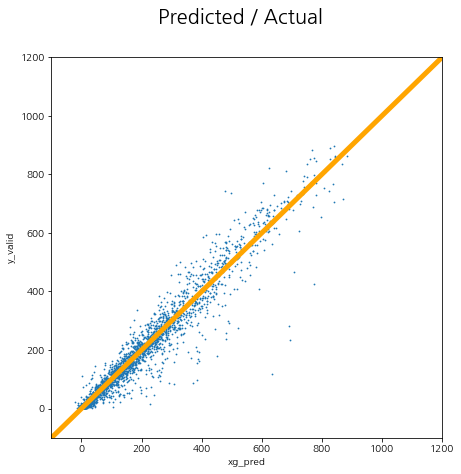

In [97]:
plt.figure(figsize=(7,7))
plt.scatter(xg_pred,Y_valid, s=0.6)
plt.xlim(-100,1200)
plt.ylim(-100,1200)
plt.plot([-100,1200],[-100,1200],color = 'orange', linestyle = '-', linewidth =5)
plt.suptitle("Predicted / Actual", fontsize = 20 )
plt.xlabel('xg_pred')
plt.ylabel("y_valid")

In [98]:
RSMLE(xg_pred,Y_valid)

0.4739488037201391

Making Predictions for testing set

In [99]:
test_dt =  dtr.fit(x,y)
predict_dt = test_dt.predict(X_test)
dt_clipped = pd.Series(predict_dt.clip(0))

In [100]:
test_rf =  regress.fit(x,y)
predict_rt = test_rf.predict(X_test)
rf_clipped = pd.Series(predict_rt.clip(0))

In [101]:
xgbtrain = xgb.DMatrix(x,label=y)
xgbtest = xgb.DMatrix(X_test)
xgmodel = xgb.train(param,xgbtrain,num_round)
xgpred = xgmodel.predict(xgbtest)
xg_clipped = pd.Series(xgpred.clip(0))

[12:16:43] WARNING: /tmp/pip-build-2kqwo3v0/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


랜덤 포리스트의 RSML은 xg Boost 및 Decison 트리에 비해 적습니다.